In [89]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [11]:
# Read the dockless data from S3 bucket
# Load the data and and call the clean method automatically to call the work flow
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [12]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")

+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

In [14]:
# Drop all records where  trip distance is less .1 miles and greater than 500 miles (1609.34 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 1609.34) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]

In [27]:
# Add to pipeline so it easy for calculations (Done)
# dockless_data['count'] = 1

# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]
weather_data = weather_data.reset_index()

In [33]:
grouped_origin_cell_id = dockless_data.groupby(['Origin Cell ID']).agg('count')
grouped_origin_cell_id = grouped_origin_cell_id.sort_values(['Trip Duration'], ascending=False)
top_origin_cell_ids = grouped_origin_cell_id['Trip Duration']
# Rename the column Trip Duration to Trip Counts
top_origin_cell_ids = top_origin_cell_ids.to_frame().reset_index()
top_50_origin_cells = top_origin_cell_ids.head(50)
top_50_origin_cells.to_csv("../../output/EDA/Top_50_Origin_Cells_Total_Rides.csv")
top_10_origin_cells = top_50_origin_cells[0:10]
top_10_origin_cells = top_10_origin_cells['Origin Cell ID'].values
top_10_origin_cells_list = top_10_origin_cells.tolist()

In [20]:
# Make the DateTime as index
dockless_data = dockless_data.reset_index()
dockless_data = dockless_data.set_index("Start Time")
origin_cell_data = dockless_data[['Origin Cell ID', 'count']]

In [34]:
top_10_origin_cell_data = origin_cell_data[origin_cell_data['Origin Cell ID'].isin(top_10_origin_cells_list)]

In [36]:
top_10_origin_cell_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111901 entries, 2018-10-22 16:15:00 to 2019-02-08 17:45:00
Data columns (total 2 columns):
Origin Cell ID    111901 non-null object
count             111901 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


In [43]:
top_10_origin_cell_data.head(5)

,Origin Cell ID,count
Start Time,,
2018-10-22 16:15:00,015019,1
2018-10-04 10:30:00,014707,1
2018-09-03 16:30:00,015019,1
2018-09-16 16:00:00,014864,1
2018-10-09 20:30:00,015019,1


In [44]:
# Top 3 origin cell data
cell_014706_data = top_10_origin_cell_data[top_10_origin_cell_data['Origin Cell ID'] == '014706']
cell_013650_data = top_10_origin_cell_data[top_10_origin_cell_data['Origin Cell ID'] == '013650']
cell_013176_data = top_10_origin_cell_data[top_10_origin_cell_data['Origin Cell ID'] == '013176']

In [97]:
trip_counts_cell_014706 = cell_014706_data.groupby([cell_014706_data.index.get_level_values(0),'Origin Cell ID']).count()
trip_counts_cell_014706 = trip_counts_cell_014706.unstack(level=1)
trip_counts_cell_014706 = trip_counts_cell_014706.fillna(0)

# Make a regular dataframe for processing the Time Series
t2 = trip_counts_cell_014706.reset_index()['count']
counts = t2['014706'].values
data = {'Start Time':trip_counts_cell_014706.index.values, '014706':counts} 
trip_counts_cell_014706_new = pd.DataFrame(data)
data_014706 = trip_counts_cell_014706_new.set_index("Start Time")



In [108]:
# data after '2018-07-15'

data_014706 = data_014706[(data_014706.index > '2018-07-15')]
data_014706.head(5)

,014706
Start Time,
2018-07-15 00:30:00,1
2018-07-15 07:45:00,1
2018-07-15 09:15:00,1
2018-07-15 09:30:00,2
2018-07-15 10:45:00,1


In [185]:

def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Dockless Scooter Trend For {}".format(name))

def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Moving Average Trend For {}".format(name))
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).ix[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Seasonality Trend For {}".format(name))
    ax.plot(series.index, seasons_average_trend)
    
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")
    
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [99]:
#trip_counts_cell_014706.head(5)

In [100]:
#trip_counts_cell_014706.index.values

In [101]:
# t2 = trip_counts_cell_014706.reset_index()['count']
# counts = t2['014706'].values

In [155]:
# data = {'Start Time':trip_counts_cell_014706.index.values, '014706':counts} 
# trip_counts_cell_014706_new = pd.DataFrame(data)
# data_014706 = trip_counts_cell_014706_new.set_index("Start Time")
data_014706.head(5)

,014706
Start Time,
2018-07-15 00:30:00,1
2018-07-15 07:45:00,1
2018-07-15 09:15:00,1
2018-07-15 09:30:00,2
2018-07-15 10:45:00,1


In [157]:
data_014706_hourly = data_014706.resample('H', how='sum')
data_014706_hourly = data_014706_hourly.fillna(0)
data_014706_hourly.head(20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


,014706
Start Time,
2018-07-15 00:00:00,1
2018-07-15 01:00:00,0
2018-07-15 02:00:00,0
2018-07-15 03:00:00,0
2018-07-15 04:00:00,0
2018-07-15 05:00:00,0
2018-07-15 06:00:00,0
2018-07-15 07:00:00,1
2018-07-15 08:00:00,0


In [158]:
data_014706_hourly['014706'].max()

34

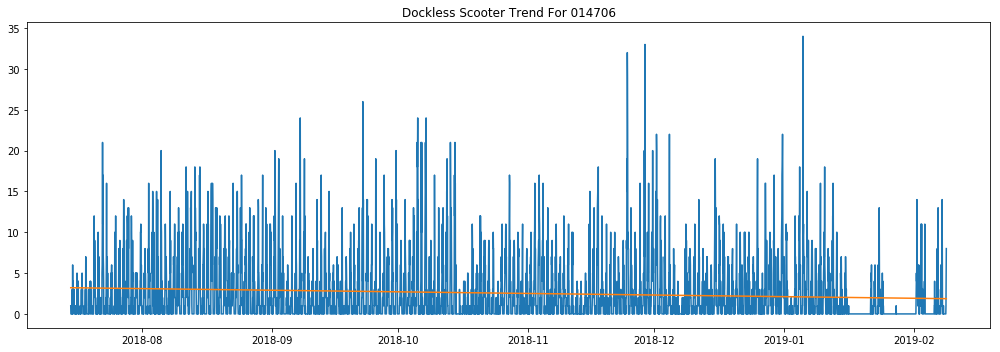

In [159]:
fig, ax = plt.subplots(1, figsize=(14, 5))
plot_linear_trend(ax, '014706', data_014706_hourly['014706'])
plt.tight_layout()

##### From the graph above you can see there is no linear trend

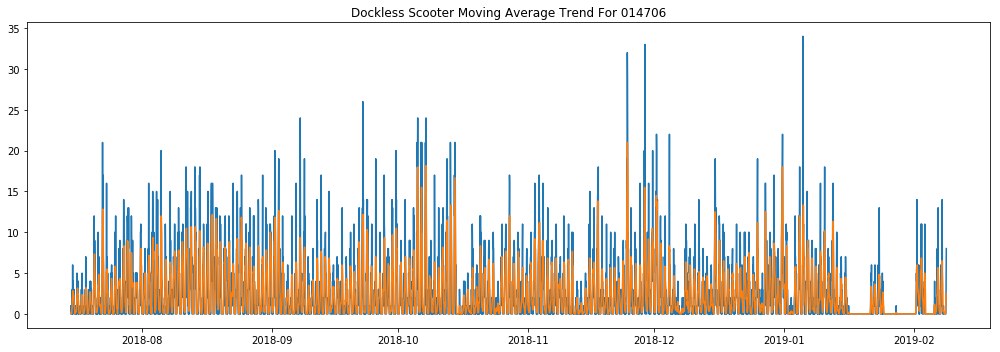

In [160]:
fig, ax = plt.subplots(1, figsize=(14, 5))
plot_moving_average_trend(ax, '014706', data_014706_hourly['014706'])
plt.tight_layout()

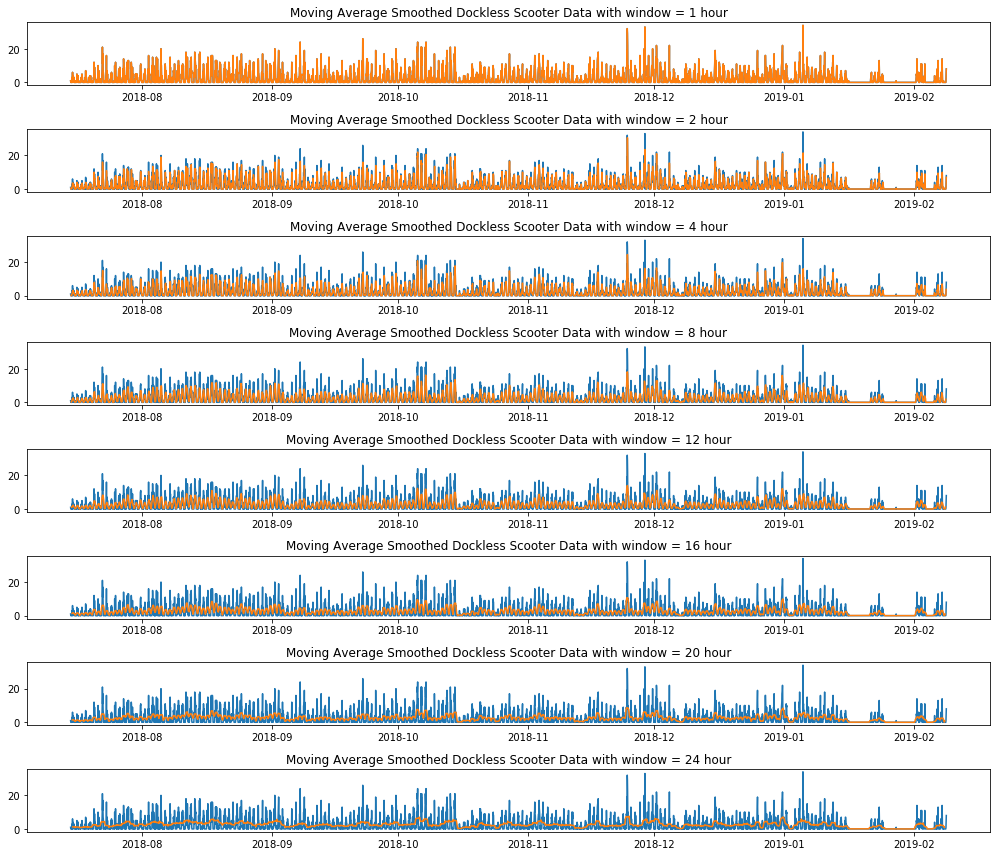

In [161]:
fig, axs = plt.subplots(8, figsize=(14, 12))

#gmail_series = google_trends['gmail']
for i, window in enumerate([1, 2, 4, 8, 12, 16, 20, 24]):
    axs[i].plot(data_014706_hourly.index, data_014706_hourly)
    axs[i].plot(data_014706_hourly.index, fit_moving_average_trend(data_014706_hourly, window=window))
    axs[i].set_title("Moving Average Smoothed Dockless Scooter Data with window = {} hour".format(window))
    
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


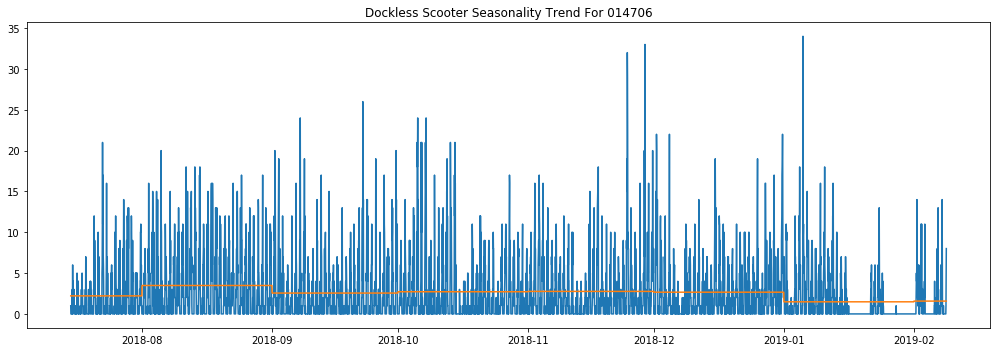

In [162]:
fig, axs = plt.subplots(1, figsize=(14, 5))

plot_seasonal_trend(axs, '014706', data_014706_hourly['014706'])

plt.tight_layout()

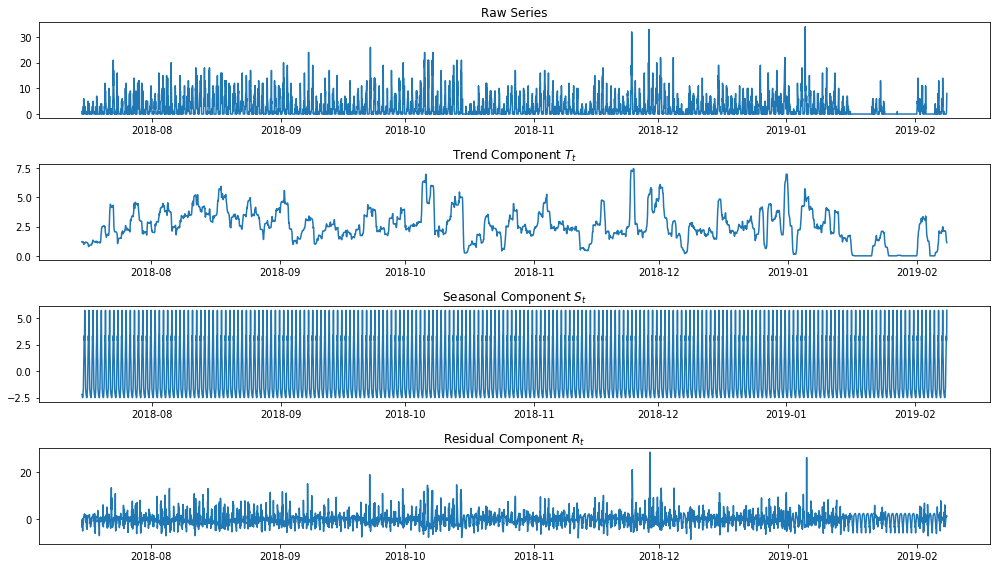

In [163]:
data_014706_decomposition = sm.tsa.seasonal_decompose(data_014706_hourly['014706'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, data_014706_hourly['014706'], data_014706_decomposition)
plt.tight_layout()

All the series above are sampled from a stationary process.

A linear combination of white noise is traditionally called a MA series.

An MA(1) contains one lagged term: $s_i = \mu + e_i + a_1 e_{i-1}$
An MA(2) contains two lagged terms: $s_i = \mu + e_i + a_1 e_{i-1} + a_2 e_{i-2}$
And so on...
Note: MA stands for moving average, even though this has nothing to do with a moving average as we discussed earlier. Unfortunately, the name has stuck, and you'll have to get use to it. My recommendation is to call them "em ay" series, and reserve the full words for true moving averages.

Tests for Stationarity
Stationarity can be hard to visualize, so there are some statistical hypothesis tests that you can use to indicate stationarity.

The Augmented Dickey-Fuller test is setup as follows:

$H_0$: The series is not-stationary.
$H_{\text{a}}$: The series is stationary.
It is available in stats models as tsa.stattools.adfuller.

In [165]:
test = sm.tsa.stattools.adfuller(data_014706_hourly['014706'])
print("ADF p-value for 014706 series: {0:2.2f}".format(test[1]))

ADF p-value for 014706 series: 0.00


The p-value is 0.00 so it is stationary

In [167]:
test = sm.tsa.stattools.adfuller(data_014706_hourly['014706'].diff()[1:])
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


The p-value of difference one is 0.00 so it is stationary too

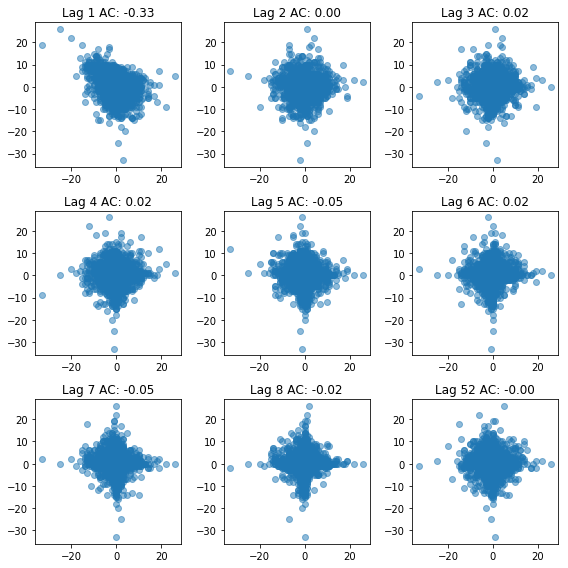

In [168]:
hourly_014706_diff = data_014706_hourly['014706'].diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [1,2,3,4,5,6,7,8,52]

for i, ax in zip(lags,axs.flatten()):
    series, lagged = series_and_lagged(hourly_014706_diff, lag=i)
    autocorr = compute_autocorrelation(hourly_014706_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

##### AutoCorrelation

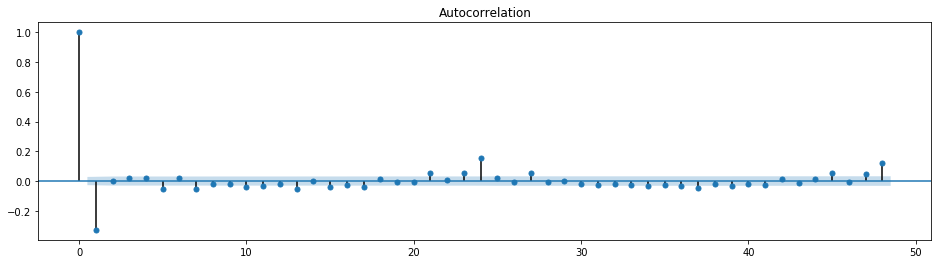

In [179]:
## Lags is 24 - 24 hours

fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(hourly_014706_diff, lags=2*24, ax=ax)

##### Partial AutoCorrelation

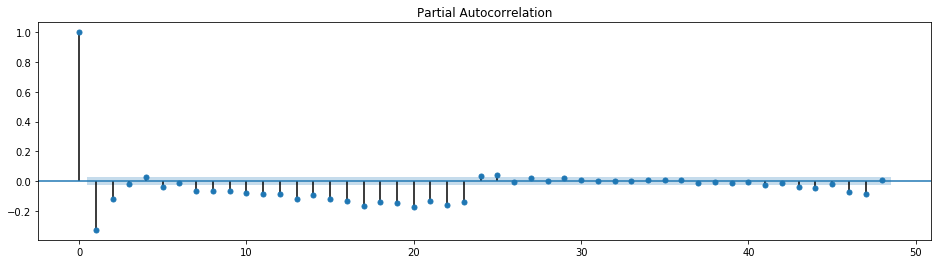

In [178]:
# Lags is 24 - 24 hours

fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(hourly_014706_diff, lags=2*24, ax=ax, method='ywmle')

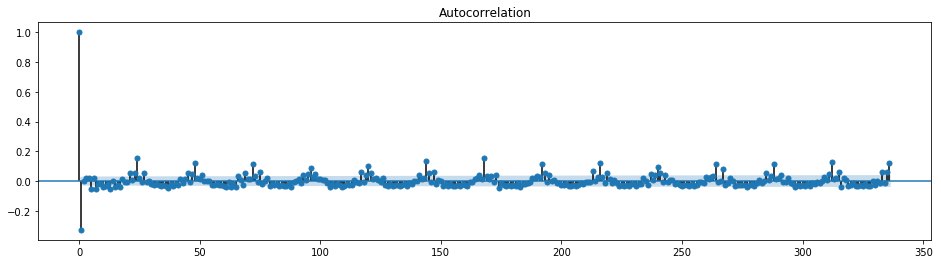

In [180]:
## Lags is 168 - 24 x 7 hours

fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(hourly_014706_diff, lags=2*168, ax=ax)

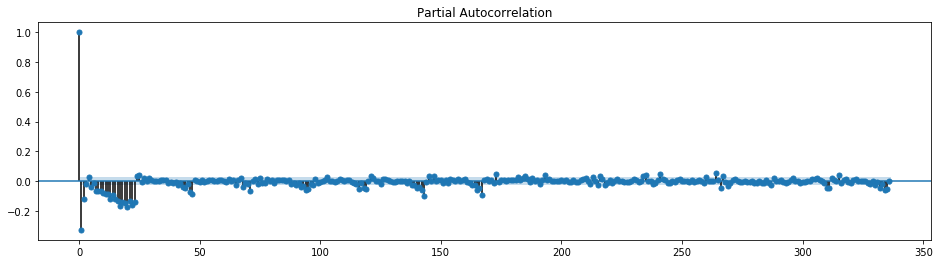

In [181]:
## Lags is 168 - 24 x 7 hours

fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(hourly_014706_diff, lags=2*168, ax=ax, method='ywmle')

##### ARIMA Model

In [183]:

scooter_model = ARIMA(data_014706_hourly, order=(0, 0, 0)).fit()

In [186]:
print("ARIMA(0, 0, 0) coefficients from Scooter model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    scooter_model.params[0], 
        format_list_of_floats(list(scooter_model.params[1:]))
    ))

ARIMA(0, 0, 0) coefficients from Scooter model:
  Intercept 2.54
  AR []


TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

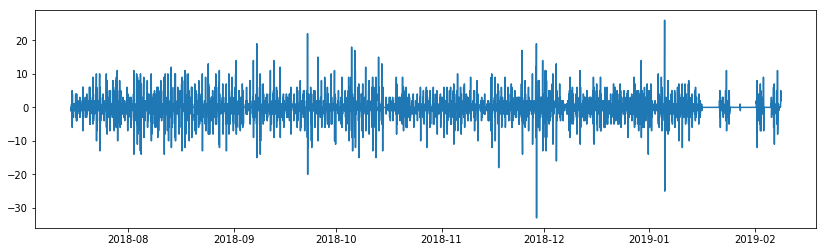

In [190]:
#hourly_014706_diff.reindex(pd.DatetimeIndex(start='01-1996', end='12-2012', freq='M'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(hourly_014706_diff.index, hourly_014706_diff)
fig = scooter_model.plot_predict('2018-11-30', '2019', dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Scooter Forcasts from ARIMA Model")

In [ ]:
### Look into this code for ARIMA 

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()